In [387]:
# Project Team:
# Iman Mohammadi
# Alireza Haqi

In [388]:
# وارد کردن کتابخانه‌های مورد نیاز
import numpy as np
import random
import matplotlib.pyplot as plt

In [389]:
# تعریف کلاس سرویس
class Service:
    def __init__(self, name, average_service_time, distribution, variance=0, service_id=0):
        # مقداردهی اولیه مشخصات سرویس
        self.id = service_id
        self.name = name
        self.average_service_time = average_service_time
        self.distribution = distribution
        self.variance = variance

In [390]:
# تعریف کلاس مشتری
class Customer:
    customer_id = 0 # شماره شناسایی مشتری، به صورت استاتیک تعریف شده تا برای هر مشتری یکتا باشد
    def __init__(self, service_type, arrival_time, workload=1000):
        # مقداردهی اولیه مشخصات مشتری
        self.id = Customer.customer_id
        Customer.customer_id += 1
        self.service_type = service_type
        self.arrival_time = arrival_time
        self.finish_time = 0
        self.workload = workload
        self.spent_time = 0
        self.wait_time = 0
        self.assigned_employee = None

    def update_time(self, t):
        # بروزرسانی زمان سپری شده برای مشتری و تعیین اتمام سرویس
        if self.assigned_employee is not None:
            self.spent_time += 1
            if self.workload - self.spent_time <= 0:
                self.finish_time = t
                return True
        else:
            self.wait_time += 1
        return False

    def detach(self, queueManager, employee_id):
        # جدا کردن مشتری از کارمند و اضافه کردن مجدد به صف
        if self.assigned_employee is not None and self.assigned_employee.id == employee_id:
            self.assigned_employee = None
            queueManager.add_customer_to_queue(self)

    def set_finish_time(self, t):
        # تنظیم زمان اتمام سرویس برای مشتری
        self.finish_time = t

In [391]:
# تعریف کلاس کارمند
class Employee:
    employee_id = 0 # شماره شناسایی کارمند، به صورت استاتیک تعریف شده تا برای هر کارمند یکتا باشد
    def __init__(self, category):
        # مقداردهی اولیه مشخصات کارمند
        self.id = Employee.employee_id
        Employee.employee_id += 1
        self.category = category
        self.task_type = None
        self.assigned_customer = None
        self.change_schedule = self.generate_schedule()
        self.service_time = 0
        self.task_time = {}

    def update_time(self, t):
        # بروزرسانی زمان و تغییر وظیفه کارمند بر اساس برنامه زمان‌بندی
        for t_s in self.change_schedule:
            if t_s[0] == t and t_s[1] != self.task_type:
                self.task_type = t_s[1]
                return True
        return False

    def assign(self, customer):
        # اختصاص دادن مشتری به کارمند
        self.assigned_customer = customer
        customer.assigned_employee = self

    def detach(self):
        # جدا کردن مشتری از کارمند
        if self.assigned_customer is not None:
            self.assigned_customer.assigned_employee = None
            self.assigned_customer = None

    def generate_schedule(self):
        # تولید برنامه زمان‌بندی برای کارمند بر اساس دسته‌بندی کاری
        type = self.category
        if type == 'A':
            return self.generate_matrix([[0.8, 0.2], [0.1, 0.9]], label=["tgd", "tsh"], time_step=5)
        elif type == 'B':
            return self.generate_matrix([[0.85, 0.15], [0.05, 0.95]], ['sdk', 'sdb'], 10)
        else:
            return self.generate_matrix([[0.8, 0.1, 0.1], [0.15, 0.75, 0.1], [0.05, 0.05, 0.9]], ['sdk', 'sdb', 'tm'], 7)

    def generate_matrix(self, Tr, label, time_step, step_max=1000):
        # تولید ماتریس برنامه زمان‌بندی برای کارمند
        N = len(label)
        ans = []
        index = 0
        for i in range(step_max):
            ans.append((time_step * i, label[index]))
            y = random.random()
            total = 0
            for j in range(N):
                total += Tr[index][j]
                if y <= total:
                    index = j
                    break
        return ans

    def assign(self, customer_id):
        # اختصاص دادن مشتری به کارمند بر اساس شناسه مشتری
        self.assigned_customer = customer_id

In [392]:
# تعریف کلاس مدیریت صف
class QueueManager:
    def __init__(self):
        # مقداردهی اولیه مشخصات مدیریت صف
        services = ["tgd", "tsh", "tm", "sdk", "sdb"]
        self.queues = {service: [] for service in services}
        self.disciplines = {"tgd": "spt", "tsh": "fifo", "tm": "fifo", "sdk": "spt", "sdb": "siro"}
        self.employees = []
        self.customers = []
        self.all_customers = []
        self.pruned_customers = []
        for key in self.disciplines.keys():
            self.all_customers.extend(self.generate_customers(key))

    def summing_list(self, Z):
      # محاسبه لیست جمع‌زده از زمان‌های ورود مشتریان
      inted = [np.ceil(z) for z in Z]
      ans = []
      sum = 0
      for i in range(len(inted)):
        sum += inted[i]
        ans.append(sum)
      return ans

    def generate_customers(self, task_type='tgd'):
        # تولید مشتریان بر اساس نوع سرویس و توزیع زمانی
        Max = 1000
        type_distribution = {"tgd": 35, "tsh": 24, "tm": 10, "sdk": 5, "sdb": 10}

        if task_type == 'tgd':
            Z = np.random.normal(40, 6, Max)
        elif task_type == 'tm':
            Z = np.random.gamma(1, 2, Max) * 60
        elif task_type == 'tsh':
            Z = np.random.exponential(0.5, Max) * 60
        elif task_type == 'sdb':
            Z = np.random.normal(15, 6, Max)
        else:
            Z = np.random.exponential(0.06, Max)
        W = self.summing_list(Z)
        ans = []
        for t in W:
            ans.append(Customer(task_type, t, np.ceil(np.random.exponential(type_distribution.get(task_type)))))
        return ans

    def update_customer_status(self, t):
        # بروزرسانی وضعیت مشتریان در صف و سیستم
        for customer in self.customers:
            if customer.update_time(t):
                self.customers.remove(customer)
                customer.assigned_employee.detach()
                customer.assigned_employee = None

    def update_employee_status(self, t):
        # بروزرسانی وضعیت کارمندان و تغییر وظیفه در صورت نیاز
        for employee in self.employees:
            if employee.update_time(t):
                if employee.assigned_customer is not None:
                    employee.detach()

    def add_employee(self, employee):
        # اضافه کردن کارمند به سیستم
        self.employees.append(employee)

    def add_customer(self, customer):
        # اضافه کردن مشتری به صف و سیستم
        self.customers.append(customer)
        self.queues.get(customer.service_type).append(customer)

    def assign_tasks(self):
        # اختصاص دادن مشتریان از صف به کارمندان بر اساس انضباط صف
        for customer in self.customers:
          if customer not in self.queues.get(customer.service_type):
            self.queues.get(customer.service_type).append(customer)

        for employee in self.employees:
            if employee.assigned_customer is None and employee.task_type:
                relevant_queue = self.queues.get(employee.task_type, [])
                if relevant_queue:
                    selected_customer = self.select_based_discipline(self.disciplines[employee.task_type], relevant_queue)
                    if selected_customer:
                        employee.assign(selected_customer)
                        relevant_queue.remove(selected_customer)
                        selected_customer.assigned_employee = employee

    def select_based_discipline(self, discipline, queue):
        # انتخاب مشتری از صف بر اساس انضباط صف مربوطه
        if discipline == 'fifo':
            return queue[0]
        elif discipline == 'siro':
            return queue[random.randrange(len(queue))]
        else:
            return min(queue, key=lambda c: c.workload - c.spent_time)

In [393]:
# جمع‌آوری داده‌های مربوط به کارمندان
def collect_employee_task_data(queue_manager):
    employee_task_data = {}
    for employee in queue_manager.employees:
        if not hasattr(employee, 'task_time'):
            continue  # اگر employee داده‌ای ندارد، ادامه نده
        for task, time in employee.task_time.items():
            if employee.id not in employee_task_data:
                employee_task_data[employee.id] = {}
            if task not in employee_task_data[employee.id]:
                employee_task_data[employee.id][task] = 0
            employee_task_data[employee.id][task] += time
    return employee_task_data

In [394]:
# بروزرسانی زمان کاری کارمند بر اساس نوع وظیفه
def update_employee_task_time(employee, task_type, service_time):
    if task_type not in employee.task_time:
        employee.task_time[task_type] = 0
    employee.task_time[task_type] += service_time

In [395]:
# تعریف کلاس برای ذخیره‌سازی داده‌های شبیه‌سازی
class SimulationData:
    def __init__(self):
        self.customer_data = []
        self.employee_data = {category: [] for category in ['A', 'B', 'C']}

    # ثبت داده‌های مشتری پس از اتمام سرویس
    def record_customer(self, customer):
        self.customer_data.append({
            'service_type': customer.service_type,
            'arrival_time': customer.arrival_time,
            'service_time': customer.finish_time - customer.arrival_time,
            'wait_time': customer.wait_time
        })

    # ثبت زمان کاری کارمندان برای هر نوع وظیفه
    def record_employee(self, employee, service_time):
        self.employee_data[employee.category].append({
            'task': employee.current_task,
            'service_time': service_time
        })

In [396]:
# تعریف سرویس‌های مختلف و مشخصات آن‌ها
services = {
          "تنظیم قرارداد": Service("تنظیم قرارداد", 30, "exponential"),
          "تنظیم شکایت": Service("تنظیم شکایت", 25, "exponential"),
          "تایید مدارک": Service("تایید مدارک", 10, "exponential"),
          "ثبت درخواست کارشناسی": Service("ثبت درخواست کارشناسی", 5, "exponential"),
          "ثبت درخواست بازبینی": Service("ثبت درخواست بازبینی", 10, "exponential")
        }

In [397]:
# اجرای شبیه‌سازی و مدیریت روند کار
def run_simulation(num_employees_per_category, total_simulation_time):

    # ایجاد نمونه از مدیریت صف
    queue_manager = QueueManager()
    for _ in range(num_employees_per_category):

        # افزودن کارمندان به سیستم بر اساس دسته‌بندی
        queue_manager.add_employee(Employee('A'))
        queue_manager.add_employee(Employee('B'))
        queue_manager.add_employee(Employee('C'))

    # اجرای شبیه‌سازی در بازه زمانی مشخص
    current_time = 0
    while current_time < total_simulation_time:

        # اضافه کردن مشتریان به سیستم بر اساس زمان ورودشان
        for c in queue_manager.all_customers:
            if c.arrival_time == current_time:
                queue_manager.add_customer(c)

        # بروزرسانی وضعیت مشتریان و کارمندان
        queue_manager.update_customer_status(current_time)
        queue_manager.update_employee_status(current_time)

        # اختصاص دادن مشتریان به کارمندان
        queue_manager.assign_tasks()
        current_time += 1

    # حذف مشتریانی که زمان ورودشان پس از پایان شبیه‌سازی است
    for customer in queue_manager.all_customers:
      if customer.arrival_time < total_simulation_time:
        queue_manager.pruned_customers.append(customer)
    queue_manager.all_customers = queue_manager.pruned_customers

    return queue_manager

In [398]:
# تابع برای نمایش توزیع زمان‌های ورود مشتریان
def plot_customer_arrivals(queue_manager):
    arrival_times = [customer.arrival_time for customer in queue_manager.all_customers]
    plt.figure(figsize=(10, 6))
    plt.hist(arrival_times, bins=50, alpha=0.7)
    plt.title("Distribution of Customer Arrivals Over Time")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Number of Customer Arrivals")
    plt.show()

In [399]:
# تابع برای نمایش زمان‌های بین ورود مشتریان
def plot_inter_arrival_times(queue_manager):
    arrival_times = [customer.arrival_time for customer in queue_manager.all_customers]
    arrival_times = sorted(arrival_times)
    inter_arrival_times = np.diff(arrival_times)
    plt.figure(figsize=(10, 6))
    plt.plot(inter_arrival_times)
    plt.title("Inter-Arrival Times of Customers")
    plt.xlabel("Customer")
    plt.ylabel("Time Between Arrivals")
    plt.show()

# تابع برای نمایش زمان سرویس دهی به هر مشتری
def plot_service_times(queue_manager):
    service_times = [customer.finish_time - customer.arrival_time for customer in queue_manager.all_customers if customer.finish_time > 0]
    plt.figure(figsize=(10, 6))

    plt.plot(service_times)
    plt.title("Service Times for Each Customer")
    plt.xlabel("Customer")
    plt.ylabel("Service Time")
    plt.show()

#تابع برای نمایش کل زمان سپری شده هر مشتری در سیستم
def plot_total_times_in_system(queue_manager):
    total_times = [customer.finish_time - customer.arrival_time for customer in queue_manager.all_customers if customer.finish_time > 0]
    plt.figure(figsize=(10, 6))
    plt.plot(total_times)
    plt.title("Total Time Spent in System by Each Customer")
    plt.xlabel("Customer")
    plt.ylabel("Total Time in System")
    plt.show()

#تابع برای نمایش زمان انتظار هر مشتری در صف
def plot_wait_times_in_queue(queue_manager):
    wait_times = [customer.wait_time for customer in queue_manager.all_customers]
    plt.figure(figsize=(10, 6))
    plt.plot(wait_times)
    plt.title("Waiting Times in Queue for Each Customer")
    plt.xlabel("Customer")
    plt.ylabel("Wait Time in Queue")
    plt.show()

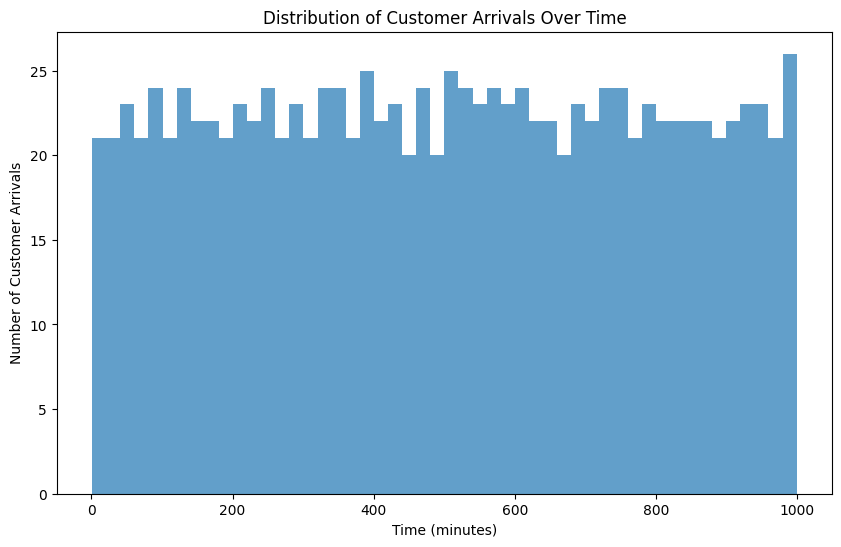

In [400]:
num_employees_per_category = 6
total_simulation_time = 1000
queue_manager = run_simulation(num_employees_per_category, total_simulation_time)
plot_customer_arrivals(queue_manager)

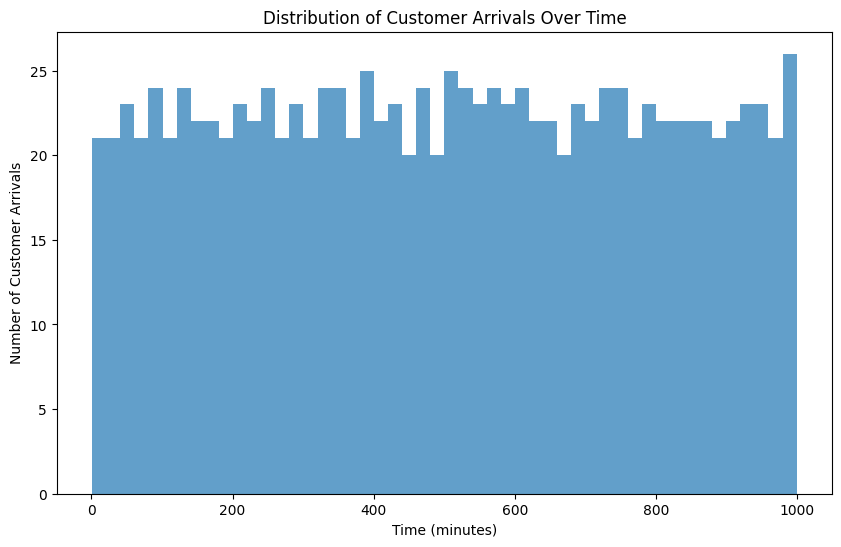

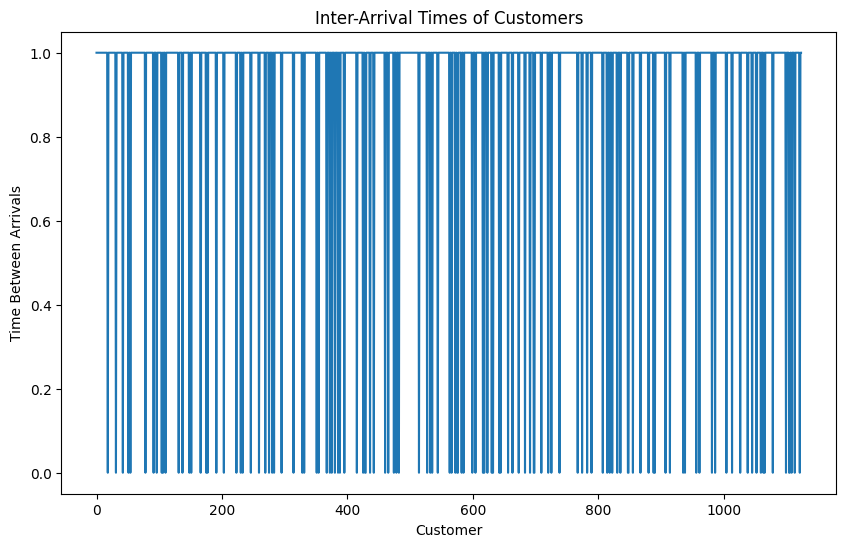

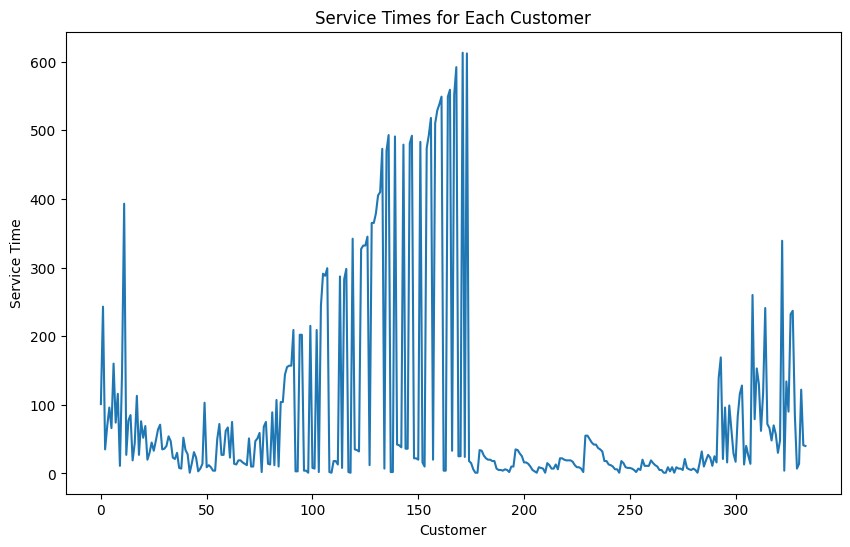

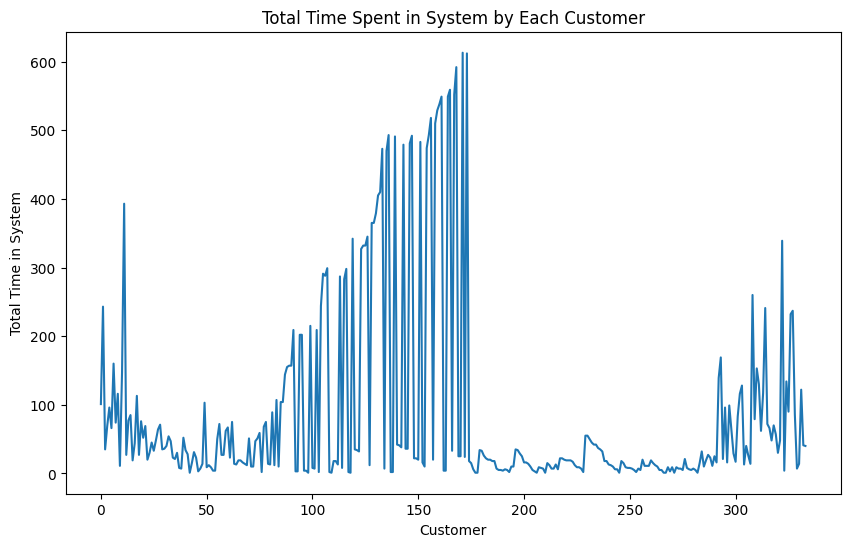

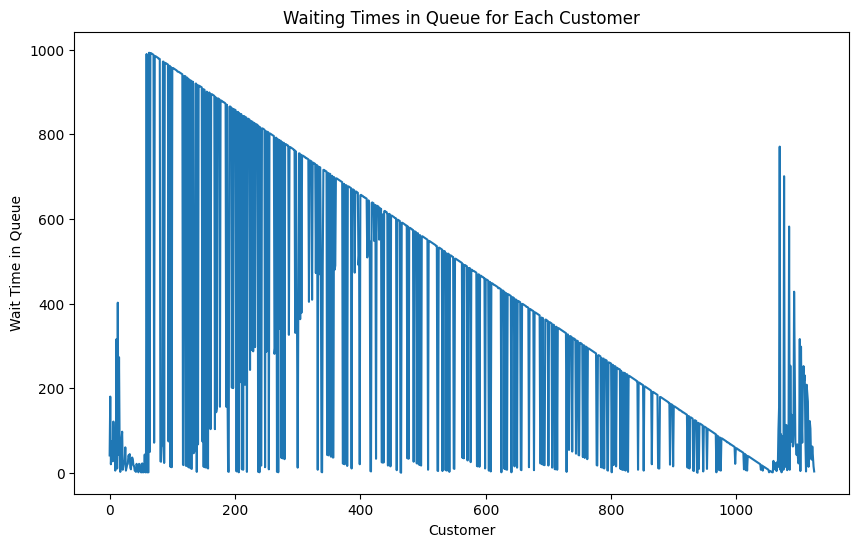

In [401]:
# رسم نمودارهای مربوط به ورود مشتریان، زمان‌های بین ورود، زمان سرویس دهی، کل زمان سپری شده در سیستم، و زمان انتظار در صف
plot_customer_arrivals(queue_manager)
plot_inter_arrival_times(queue_manager)
plot_service_times(queue_manager)
plot_total_times_in_system(queue_manager)
plot_wait_times_in_queue(queue_manager)

In [402]:
#تابع برای رسم نمودار خطی
def plot_line_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

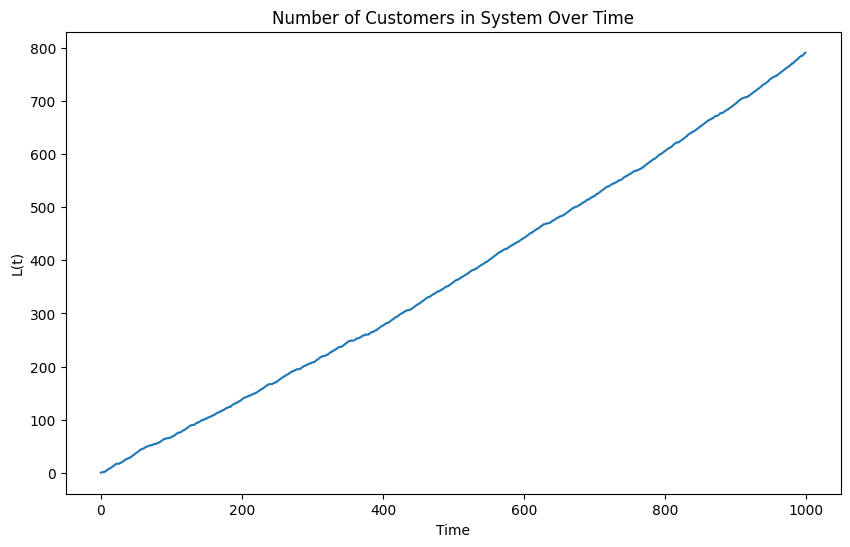

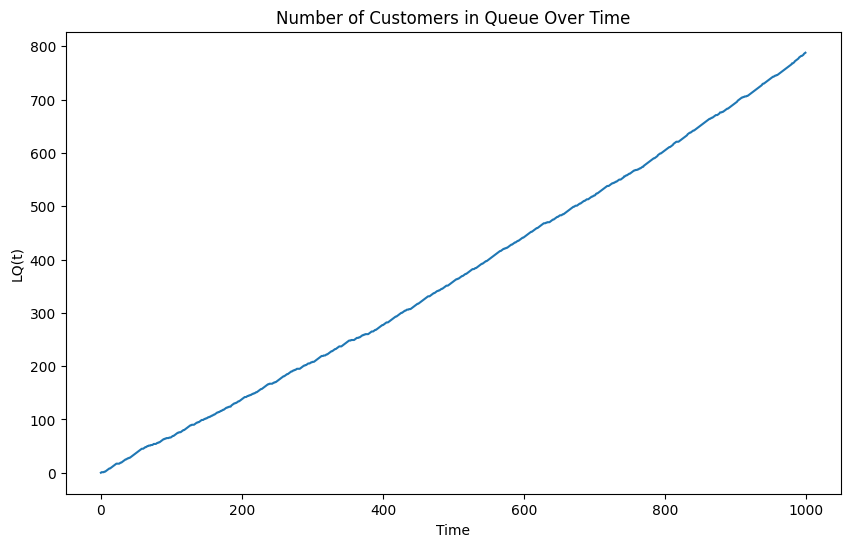

In [403]:
L_t = []
LQ_t = []
Wn = []
WnQ = []

for time in range(total_simulation_time):
    L_t.append(len([c for c in queue_manager.customers if c.arrival_time <= time and (c.finish_time > time or c.finish_time == 0)]))
    LQ_t.append(sum([1 for c in queue_manager.customers if c.arrival_time <= time and c.assigned_employee is None]))

for customer in queue_manager.customers:
    Wn.append(customer.finish_time - customer.arrival_time if customer.finish_time > 0 else total_simulation_time - customer.arrival_time)
    WnQ.append(customer.wait_time)

avg_L_t = np.mean(L_t) if L_t else 0
avg_LQ_t = np.mean(LQ_t) if LQ_t else 0
avg_Wn = np.mean(Wn) if Wn else 0
avg_WnQ = np.mean(WnQ) if WnQ else 0

plot_line_chart(L_t, "Number of Customers in System Over Time", "Time", "L(t)")
plot_line_chart(LQ_t, "Number of Customers in Queue Over Time", "Time", "LQ(t)")

In [404]:
print(avg_L_t)
print(avg_LQ_t)
print(avg_Wn)
print(avg_WnQ)

370.717
370.314
468.66877370417194
468.14917825537293


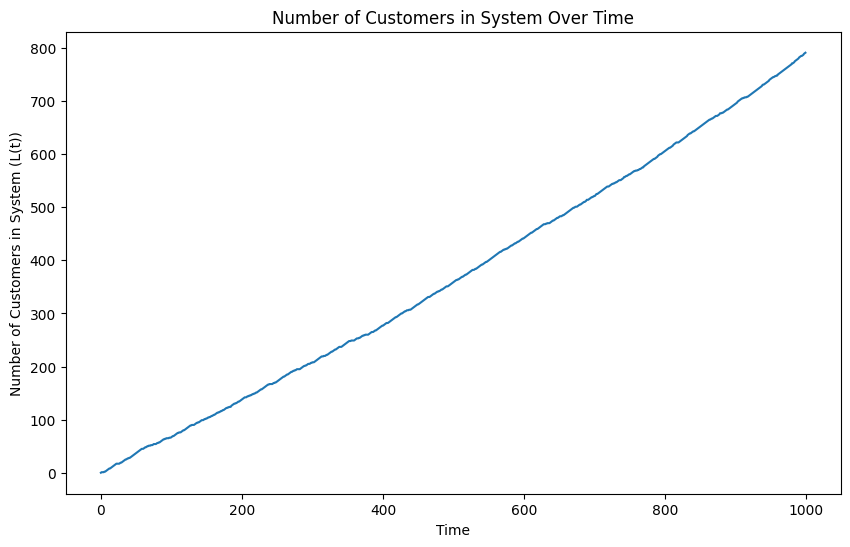

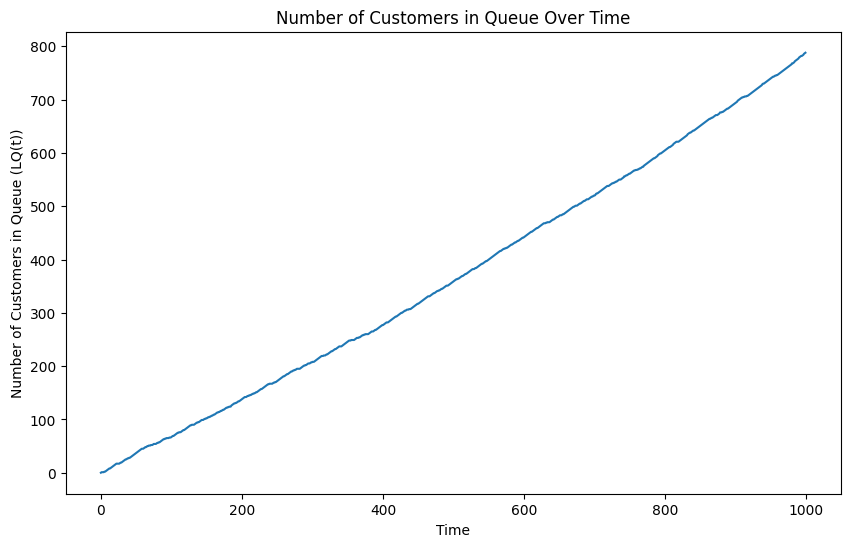

In [405]:
plot_line_chart(L_t, "Number of Customers in System Over Time", "Time", "Number of Customers in System (L(t))")
plot_line_chart(LQ_t, "Number of Customers in Queue Over Time", "Time", "Number of Customers in Queue (LQ(t))")

avg_L_t = np.mean(L_t) if L_t else 0
avg_LQ_t = np.mean(LQ_t) if LQ_t else 0

avg_L_t, avg_LQ_t

#تابع برای نمایش توزیع کاری کارمندان
def plot_employee_task_distribution(employee_task_data):
    for employee_id, tasks in employee_task_data.items():
        labels = list(tasks.keys())
        sizes = list(tasks.values())
        plt.figure(figsize=(10, 6))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.title(f'Task Distribution for Employee {employee_id}')
        plt.show()

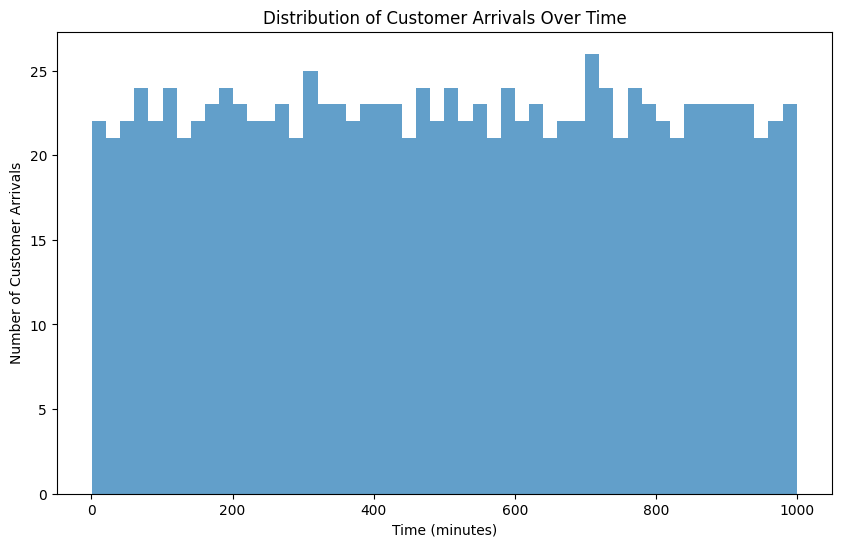

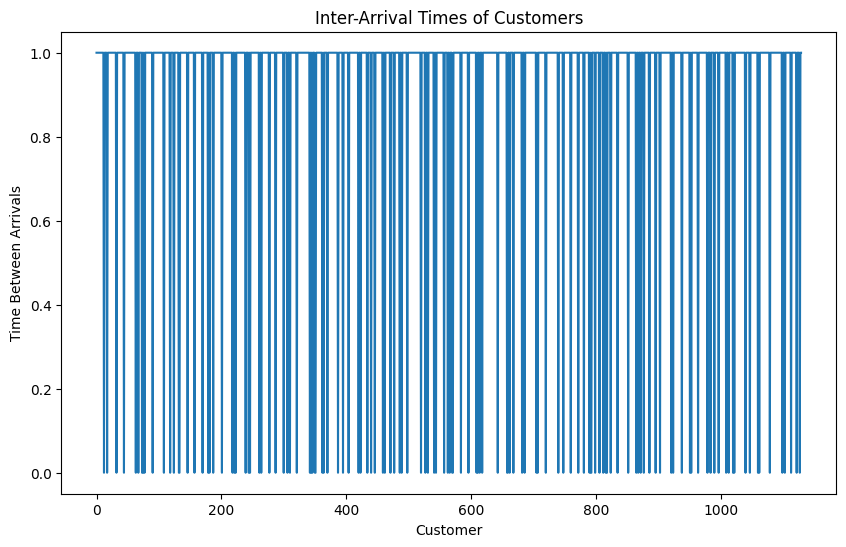

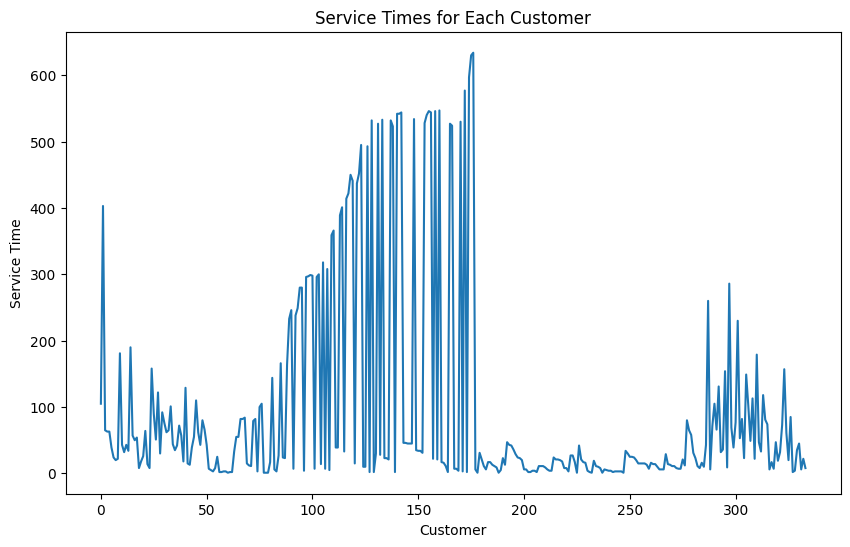

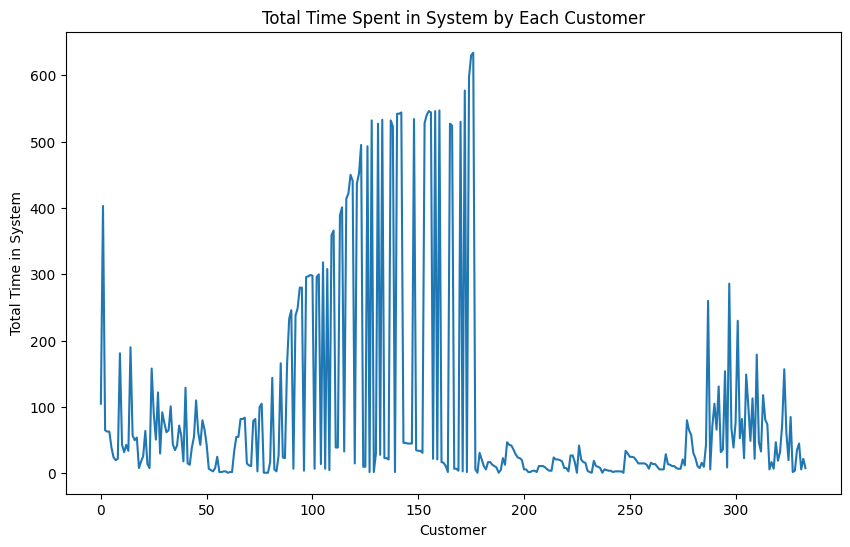

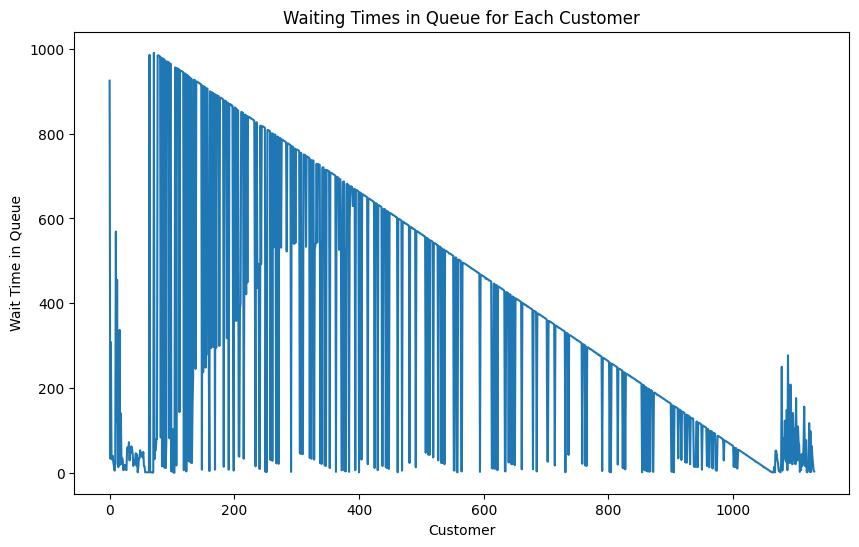

In [406]:
for employee in queue_manager.employees:
    employee.task_time = {}

for employee in queue_manager.employees:
    for customer in queue_manager.customers:
        if customer.assigned_employee == employee:
            task_type = customer.service_type
            update_employee_task_time(employee, task_type, customer.spent_time)

queue_manager = run_simulation(num_employees_per_category, total_simulation_time)

employee_task_data = collect_employee_task_data(queue_manager)

def plot_employee_task_distribution(employee_task_data):
    for employee_id, tasks in employee_task_data.items():
        labels = list(tasks.keys())
        sizes = list(tasks.values())
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.title(f"Task Distribution for Employee {employee_id}")
        plt.show()

plot_employee_task_distribution(employee_task_data)

plot_customer_arrivals(queue_manager)
plot_inter_arrival_times(queue_manager)
plot_service_times(queue_manager)
plot_total_times_in_system(queue_manager)
plot_wait_times_in_queue(queue_manager)

<div dir="rtl">

توزیع زمان ورود مشتریان به سیستم
این نمودار نشان‌دهنده توزیع زمانی ورود مشتریان به سیستم است. با توجه به توزیع ورودی که برای هر خدمت تعریف شده، این نمودار تغییرات تراکم ورود مشتریان در بازه‌های زمانی مختلف را نشان می‌دهد. تراکم بالا ممکن است نیاز به منابع بیشتر برای پاسخگویی در زمان‌های خاص را نشان دهد.

زمان‌های بین ورود مشتریان
این نمودار زمان بین ورود دو مشتری متوالی را نشان می‌دهد. تغییرات در این نمودار می‌تواند درک بهتری از فشار ورودی به سیستم در زمان‌های مختلف فراهم کند. زمان‌های طولانی‌تر بین ورود نشان‌دهنده دوره‌های کم‌تراکم و زمان‌های کوتاه‌تر نشان‌دهنده دوره‌های پیک است.

زمان سرویس دهی به هر مشتری
این نمودار زمان لازم برای ارائه خدمت به هر مشتری را نشان می‌دهد. این اطلاعات می‌توانند برای ارزیابی کارایی پرسنل و تخصیص منابع در زمان‌های مختلف مورد استفاده قرار گیرند.

کل زمان سپری شده توسط هر مشتری در سیستم
این نمودار کل زمانی را که یک مشتری از ورود تا خروج در سیستم سپری می‌کند، نشان می‌دهد. این شامل زمان انتظار در صف و زمان سرویس دهی است. زمان‌های طولانی‌تر ممکن است نشان‌دهنده نیاز به بهبود فرآیندها یا افزایش منابع باشد.

زمان انتظار هر مشتری در صف
این نمودار زمانی را که مشتریان قبل از دریافت سرویس در صف انتظار می‌کشند، نشان می‌دهد. زمان‌های انتظار طولانی می‌تواند نشان‌دهنده نیاز به بهینه‌سازی فرآیند یا افزایش تعداد کارکنان باشد.

توزیع وظایف برای کارمندان
این نمودار نشان‌دهنده توزیع کار بین کارمندان است. این تحلیل می‌تواند به مدیریت کمک کند تا عادلانه‌تر کارها را بین کارمندان تقسیم کند و اطمینان حاصل کند که هیچ کارمندی بیش از حد تحت فشار نیست.

</div>